In [1]:
!python demo.py

/Users/deven/anaconda3/envs/rl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Traceback (most recent call last):
  File "_ctypes/callbacks.c", line 234, in 'calling callback function'
  File "/Users/deven/anaconda3/envs/rl/lib/python3.6/site-packages/pyglet/libs/darwin/cocoapy/runtime.py", line 1121, in objc_method
    result = f(py_self, *args)
  File "/Users/deven/anaconda3/envs/rl/lib/python3.6/site-packages/pyglet/window/cocoa/pyglet_window.py", line 64, in nextEventMatchingMask_untilDate_inMode_dequeue_
    if self.inLiveResize():
  File "/Users/deven/anaconda3/envs/rl/lib/python3.6/site-packages/pyglet/libs/darwin/cocoapy/runtime.py", line 785, in __call__
    return self.method(self.objc_id, *args)
  F

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Softmax
from tensorflow.keras.models import Sequential

In [22]:
!pip install matplotlib

In [6]:
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def simpleModel( inputShape, nOutputs ):
    model = Sequential()
    model.add(Dense(32, input_shape=inputShape))
    model.add( Activation( tf.nn.leaky_relu ) )
    model.add(Dense(32))
    model.add( Activation( tf.nn.leaky_relu ) )
    model.add(Dense(nOutputs, activation="linear"))
    return model

class Buffer( object ):
    def __init__( self, buffer_length ):
        self.queue = collections.deque(maxlen=buffer_length)
    
    def push( self, touples ):
        self.queue.append( touples )
    
    def sample( self, batch_size = 32, sampler = 'experience_replay'):
        states = []
        actions = []
        rewards = []
        next_states = []
        doneList = []
        
        if sampler == 'experience_replay':
            experience_batch = random.sample( self.queue, batch_size )
        elif sampler == 'prioritized_experience_replay':
            # TODO
            experience_batch = []
        """
        for experience in experience_batch:
            state, action, reward, next_state, done = experience
            states.append( state )
            actions.append( action )
            rewards.append( reward )
            next_states.append( next_state )
            doneList.append( done )
            
        return ( states, actions, rewards, next_states, doneList )
        """
        return experience_batch
    
    def clear( self ):
        self.queue.clear()
    
    def __len__( self ):
        return len( self.queue )
    
class DQN(object):
    def __init__( self, env, sampler_strategy = 'experience_replay' ):
        self.env = env
        
        self.observation_space = env.observation_space.shape
        self.action_space = env.action_space.n
        
        self.sampler_strategy = sampler_strategy
        
        self.buffer = Buffer(1000000)
        self.targetFreezeIters = 400
        
        self.model = simpleModel( self.observation_space, self.action_space )
        self.target_model = simpleModel( self.observation_space, self.action_space )
        self.optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001, name = 'Adam')
        self.curr_reward = 0.
        self.history = []
        self.iters = []
        self.xcoords = []
        self.gamma = 0.95
        
        self.model.compile( optimizer = self.optimizer, loss="mse" )
        
    
    def solve( self, nEpisodes, batchSize ):
        exploration_rate = 0.05
        self.buffer.clear()
        iter_ = 0
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        for episode in range( nEpisodes ):
            state = self.env.reset()
            state = np.reshape(state, [1, self.observation_space[0]])
            #
            self.curr_reward = 0.
            # play till end of episode
            while True:
                # get action from model, e-greedy policy
                #env.render()
                if np.random.rand() < exploration_rate:
                    action = random.choice( range( self.action_space ) )
                else:
                    qvalues = self.model.predict( state )
                    action = np.argmax(qvalues[0])
                    
                # sample from env
                observation, reward, done, info = env.step(action)
                observation = np.reshape(observation, [1, self.observation_space[0]])
                
                self.curr_reward += reward
                # push to buffer
                self.buffer.push( (state, action, reward, observation, done ) )
                # optimize model params
                self.optimize( batchSize )
                if done:
                    print( 'Episode: {}; reward: {}; iter: {}'.format(episode, self.curr_reward, iter_))
                    break
                iter_ += 1
                # init_target_model
                if iter_ % self.targetFreezeIters == 0:
                    print( 'Q-target model updated!')
                    self.target_model.set_weights(self.model.get_weights())
                    self.xcoords.append( iter_ )
                state = observation
            self.history.append( self.curr_reward )
            self.iters.append(iter_)
            self.update_plot( ax, fig )
                    
    def optimize( self, batchSize ):
        # sample from buffer
        if len( self.buffer ) < batchSize:
            return
        batch_data = self.buffer.sample( batchSize )
        for state, action, reward, next_state, done in batch_data:
            if not done:
                q_target = reward + self.gamma*np.amax( self.target_model.predict( next_state )[0] )
            else:
                q_target = reward
            
            q_model = self.model.predict( state )
            q_model[0][action] = q_target
            # optimize the model by freezing the target network
            self.model.fit( state, q_model, verbose = 0 )
    
    def update_plot( self, ax, fig ):
        ax.cla()
        ax.plot( self.iters, self.history)
        for xc in self.xcoords:
            ax.axvline(x=xc, color='r', linestyle = '--', linewidth = 0.5)
        display(fig)
        clear_output(wait = True)
        plt.pause(0.5)

In [7]:
env = gym.make('CartPole-v0')
dqn = DQN(env)

In [8]:
env.reset()
state = env.reset()
state = np.reshape(state, [1, env.observation_space.shape[0]])
print(state)

[[-0.0364171   0.030976    0.00725827 -0.01771403]]


Episode: 124; reward: 200.0; iter: 2723


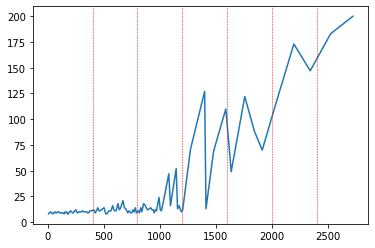

In [ ]:
# without target network
dqn.solve(500,32)